# Read All Dataset CSV

In [15]:
import os
import csv
import pandas as pd
import numpy as np

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [41]:
dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]

for folder_name in os.listdir("./Competition_data"):
    
    x_train = pd.read_csv(f"./Competition_data/{folder_name}/X_train.csv",header=0)
    y_train = pd.read_csv(f"./Competition_data/{folder_name}/y_train.csv",header=0)
    x_test = pd.read_csv(f"./Competition_data/{folder_name}/X_test.csv",header=0)  
    
    # Initialize Encoder
    label_encoder = LabelEncoder()
    OneHotEncoder_encoder = OneHotEncoder()
    standard_encoder = StandardScaler()
    minmax_encoder = MinMaxScaler()

    # seperate the categorical columns and numerical columns
    numerical_columns = []
    categorical_columns = []
    for i in x_train.columns:
        if x_train[i].dtype == 'float64':
            numerical_columns.append(i)
        else:
            categorical_columns.append(i)
            
    # copy to avoid changing the original data
    X_train_encoded = x_train.copy()
    X_test_encoded = x_test.copy()


    for col in categorical_columns:
        # Fit the one hot encoder on the combined data of train and test to avoid unseen labels
        combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
        OneHotEncoder_encoder.fit(combined_data.values.reshape(-1, 1))

        # Transform the train and test data
        train_encoded = OneHotEncoder_encoder.transform(x_train[col].values.reshape(-1, 1)).toarray()
        test_encoded = OneHotEncoder_encoder.transform(x_test[col].values.reshape(-1, 1)).toarray()

        # Create new column names for the one hot encoded columns
        train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{col}_{int(i)}" for i in range(train_encoded.shape[1])])
        test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{col}_{int(i)}" for i in range(test_encoded.shape[1])])

        # Concatenate the new one hot encoded columns to the original dataframe
        X_train_encoded = pd.concat([X_train_encoded, train_encoded_df], axis=1)
        X_test_encoded = pd.concat([X_test_encoded, test_encoded_df], axis=1)

        # Drop the original categorical columns
        X_train_encoded.drop(columns=[col], inplace=True)
        X_test_encoded.drop(columns=[col], inplace=True)

    # for col in categorical_columns:
    #     # Fit the label encoder on the combined data of train and test to avoid unseen labels
    #     combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
    #     label_encoder.fit(combined_data)

    #     X_train_encoded[col] = label_encoder.transform(x_train[col])
    #     X_test_encoded[col] = label_encoder.transform(x_test[col])

    ##  == apply standard scaler to numerical columns == ##
    # for col in numerical_columns:
    #     combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
    #     standard_encoder.fit(combined_data.values.reshape(-1, 1))

    #     X_train_encoded[col] = standard_encoder.fit_transform(x_train[col].values.reshape(-1, 1))
    #     X_test_encoded[col] = standard_encoder.transform(x_test[col].values.reshape(-1, 1))

    ##  == apply minmax scaler to numerical columns cuz we use XGBOOST and RF== ##
    for col in numerical_columns:
        combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
        minmax_encoder.fit(combined_data.values.reshape(-1, 1))

        X_train_encoded[col] = minmax_encoder.transform(x_train[col].values.reshape(-1, 1))
        X_test_encoded[col] = minmax_encoder.transform(x_test[col].values.reshape(-1, 1))

    dataset_names.append(folder_name)
    X_trains.append(X_train_encoded)
    y_trains.append(y_train)
    X_tests.append(X_test_encoded)

        

In [ ]:
X_tests[2]

## Data Preprocessing & Feature Engineering

In [38]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
for i in range(len(dataset_names)):
    # Initialize the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize RFECV
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

    x_train = X_trains[i]
    y_train = y_trains[i]

    # Fit RFECV
    rfecv.fit(X_train_encoded, y_train.values.ravel())

    # Get the selected features
    selected_features = x_train.columns[rfecv.support_]

    print("Selected features:", selected_features)

    # Transform the datasets
    X_trains[i] = X_train_encoded[selected_features]
    X_tests[i] = X_test_encoded[selected_features]

Selected features: Index(['Feature_1'], dtype='object')
Selected features: Index(['Feature_2', 'Feature_4', 'Feature_5', 'Feature_7'], dtype='object')
Selected features: Index(['Feature_2', 'Feature_4', 'Feature_43', 'Feature_60', 'Feature_61'], dtype='object')


KeyError: "['Feature_60', 'Feature_61'] not in index"

## train test split & build Model
You can select an appropriate model and perform corresponding hyperparameter tuning.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
import xgboost as xgb
from sklearn.svm import SVC

使用VotingClassifier

In [44]:
from sklearn.ensemble import VotingClassifier

y_predicts_voting = []
for i in range(len(dataset_names)):
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_trains[i], y_trains[i], test_size=0.2, random_state=42)
    
    # 準備基模型
    base_models = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ]

    # 初始化Voting Classifier
    voting_model = VotingClassifier(estimators=base_models, voting='soft')

    # 訓練Voting Classifier
    voting_model.fit(X_train_part, y_train_part)

    # 使用驗證集進行預測
    y_pred = voting_model.predict(X_valid)
    y_pred_proba = voting_model.predict_proba(X_valid)[:, 1]

    # 評估模型
    accuracy = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred_proba)

    print(f"{i} times finish")
    print(f"AUC: {auc:.2f}")

    # 使用訓練好的Voting模型來預測X_test並儲存結果
    y_test_pred = voting_model.predict_proba(X_tests[i])[:, 1]
    df = pd.DataFrame(y_test_pred, columns=['y_predict_proba'])
    y_predicts_voting.append(df)

c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0 times finish
AUC: 0.85


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1 times finish
AUC: 0.80


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


2 times finish
AUC: 0.49


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


3 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


4 times finish
AUC: 0.93


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


5 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


6 times finish
AUC: 0.78


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


7 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


8 times finish
AUC: 0.93


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


9 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


10 times finish
AUC: 0.99


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


11 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


12 times finish
AUC: 0.94


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


13 times finish
AUC: 0.99


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


14 times finish
AUC: 0.82


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


15 times finish
AUC: 0.94


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


16 times finish
AUC: 0.62


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


17 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


18 times finish
AUC: 0.85


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


19 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


20 times finish
AUC: 0.85


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


21 times finish
AUC: 0.96


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


22 times finish
AUC: 0.88


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


23 times finish
AUC: 0.83


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


24 times finish
AUC: 0.77


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


25 times finish
AUC: 0.80


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


26 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


27 times finish
AUC: 0.84


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


28 times finish
AUC: 0.86


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


29 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


30 times finish
AUC: 0.87


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


31 times finish
AUC: 0.74


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


32 times finish
AUC: 0.99


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


33 times finish
AUC: 0.46


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


34 times finish
AUC: 0.86


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


35 times finish
AUC: 0.99


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


36 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


37 times finish
AUC: 0.80


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


38 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


39 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


40 times finish
AUC: 0.92


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


41 times finish
AUC: 0.59


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


42 times finish
AUC: 1.00


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


43 times finish
AUC: 0.99


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


44 times finish
AUC: 0.84


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


45 times finish
AUC: 0.97


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


46 times finish
AUC: 0.98


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


47 times finish
AUC: 0.94


c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\OneDrive\桌面\大四上\A-general-model-for-Binary-Classification\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


48 times finish
AUC: 0.89


In [45]:
for idx,dataset_name in enumerate(dataset_names):
    df=y_predicts_voting[idx]
    df.to_csv(f'./Competition_data/{dataset_name}/y_predict.csv', index=False,header=True)

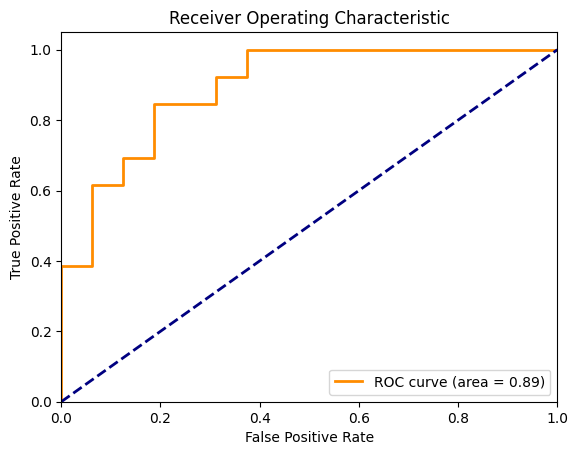

In [46]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Assuming y_valid and y_pred_proba are defined
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

使用stack處理

In [ ]:
y_predicts=[]
for i in range(len(dataset_names)):
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_trains[i], y_trains[i], test_size=0.2, random_state=42)
    
    # 準備基模型
    base_models = [  
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ]

    # 準備次級模型
    meta_model = LogisticRegression()

    # 初始化Stacking Classifier
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)

    # 訓練Stacking Classifier
    stacking_model.fit(X_train_part, y_train_part)

    # 使用驗證集進行預測
    y_pred = stacking_model.predict(X_valid)
    y_pred_proba = stacking_model.predict_proba(X_valid)[:, 1] 

    # 評估模型
    accuracy = accuracy_score(y_valid, y_pred)
    # f1 = f1_score(y_valid, y_pred, average='weighted')
    # precision = precision_score(y_valid, y_pred, average='weighted')

    # print(f"Accuracy: {accuracy:.2f}")
    # print(f"F1 Score: {f1:.2f}")
    # print(f"Precision: {precision:.2f}")
    print(f"{i}times finish")
    print(f"AUC: {accuracy:.2f}")

    # 使用訓練好的Stacking模型來預測X_test並儲存結果
    y_test_pred = stacking_model.predict_proba(X_tests[i])[:, 1] 
    df = pd.DataFrame(y_test_pred, columns=['y_predict_proba'])
    y_predicts.append(df)


## Save result

In [ ]:
for idx,dataset_name in enumerate(dataset_names):
    df=y_predicts[idx]
    df.to_csv(f'./Competition_data/{dataset_name}/y_predict.csv', index=False,header=True)

NameError: name 'y_predicts' is not defined